In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


In [2]:
DF = pd.read_csv("dataset_world_happiness.csv")
DF

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,Western Europe,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,Western Europe,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,Western Europe,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,North America,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaN,Rwanda,152,3.334,0.35900,NaN,0.61400,0.55500,0.41100,0.21700,NaN,2019
755,NaN,Tanzania,153,3.231,0.47600,NaN,0.49900,0.41700,0.14700,0.27600,NaN,2019
756,NaN,Afghanistan,154,3.203,0.35000,NaN,0.36100,0.00000,0.02500,0.15800,NaN,2019
757,NaN,Central African Republic,155,3.083,0.02600,NaN,0.10500,0.22500,0.03500,0.23500,NaN,2019


In [3]:

#*********** Cleaning Country Column ***********#
mask = DF.Country.isnull()                       # Gets index of where "Country" is null == mask
DF.loc[mask, 'Country'] = DF.loc[mask,'Region']  # Inserts the value in "Region" at the same index into "Country"   

idx = DF.Country == DF.Region   # Finds index of where "Region" == "Country"
DF.loc[idx,'Region'] = np.nan   # Replaces "Region" with NaN


#************ Cleaning Region Column *************#
for i in range(len(DF['Region'])):
    
    if pd.isnull(DF.loc[i,'Region']):   # Locating cell of Null values for Region 
        country = DF.loc[i,'Country']   # stores Country of postion i 
        
        for x in range(len(DF['Country'])):
            # going through DF['Country'] until we find 'country' value and if Region is not null 
            if DF.loc[x,'Country'] == country and pd.notnull(DF.loc[x,'Region']):
                DF.loc[i,'Region'] = DF.loc[x,'Region']  # Storing Region value from postion x into position i
                break     # Breaking out of loop / ASK TA
                
indexNullRegion = DF[DF['Region'].isnull()].index.to_numpy()
NullRegion_values = ['Southeastern Asia','Eastern Asia','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Central and Eastern Europe','Middle East and Northern Africa',
                    'Sub-Saharan Africa']
counter=0;
for i in indexNullRegion:
    if counter< 11:
        DF.loc[i,'Region'] = NullRegion_values[counter]
        counter+=1
        
#************ Cleaning Family Column ************# 

# mean for close values ; median for outliers 

RegionGrouped = DF.groupby('Region')['Family'].mean() 
# m = DF.groupby('Region')['Family'].median()
indexNullFamily = DF[DF['Family'].isnull()].index.to_numpy()

for i in indexNullFamily:
    DF.loc[i,'Family'] = RegionGrouped[DF.loc[i,'Region']]
    
#*********** Cleaning Dystopia Residual ********#

indexNullDR = DF[DF['Dystopia Residual'].isnull()].index.to_numpy()
DRmean = DF['Dystopia Residual'].mean() 
DF.loc[indexNullDR,'Dystopia Residual'] = DRmean 

# m

In [4]:
DF

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,1.39651,1.349510,0.94143,0.66557,0.41978,0.29678,2.517380,2015
1,Iceland,Western Europe,2,7.561,1.30232,1.402230,0.94784,0.62877,0.14145,0.43630,2.702010,2015
2,Denmark,Western Europe,3,7.527,1.32548,1.360580,0.87464,0.64938,0.48357,0.34139,2.492040,2015
3,Norway,Western Europe,4,7.522,1.45900,1.330950,0.88521,0.66973,0.36503,0.34699,2.465310,2015
4,Canada,North America,5,7.427,1.32629,1.322610,0.90563,0.63297,0.32957,0.45811,2.451760,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
754,Rwanda,Sub-Saharan Africa,152,3.334,0.35900,0.791847,0.61400,0.55500,0.41100,0.21700,2.092243,2019
755,Tanzania,Sub-Saharan Africa,153,3.231,0.47600,0.791847,0.49900,0.41700,0.14700,0.27600,2.092243,2019
756,Afghanistan,Southern Asia,154,3.203,0.35000,0.685964,0.36100,0.00000,0.02500,0.15800,2.092243,2019
757,Central African Republic,Sub-Saharan Africa,155,3.083,0.02600,0.791847,0.10500,0.22500,0.03500,0.23500,2.092243,2019


In [5]:
RegionGrouped

Region
Australia and New Zealand          1.283296
Central and Eastern Europe         1.066939
Eastern Asia                       1.090611
Latin America and Caribbean        1.089464
Middle East and Northern Africa    0.906077
North America                      1.269152
Southeastern Asia                  1.008165
Southern Asia                      0.685964
Sub-Saharan Africa                 0.791847
Western Europe                     1.244900
Name: Family, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1c903b3bf48>,
 'caps': [<matplotlib.lines.Line2D at 0x1c903b4cc88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c903b3bc08>],
 'medians': [<matplotlib.lines.Line2D at 0x1c903b57e08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c903b57f48>],
 'means': []}

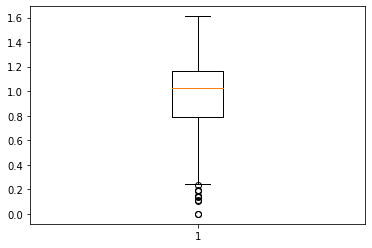

In [6]:
plt.boxplot(DF['Family'])

In [7]:
# DF =DF.dropna(axis = 0)
# DF


In [8]:
DF.describe()

,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,758.000000,759.000000,759.000000,759.000000
mean,78.753623,5.377318,0.916629,0.989978,0.613224,0.409679,0.124838,0.216846,2.092243,2016.996047
std,45.143496,1.126170,0.407404,0.266771,0.248287,0.152673,0.104820,0.120568,0.437919,1.422115
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2015.000000
25%,39.500000,4.510500,0.604024,0.791847,0.440305,0.309205,0.055000,0.129881,1.972777,2016.000000
50%,79.000000,5.314000,0.982409,1.029120,0.647380,0.431000,0.091033,0.201313,2.092243,2017.000000
75%,118.000000,6.192000,1.237500,1.162655,0.808579,0.530500,0.155225,0.275355,2.201575,2018.000000
max,158.000000,7.769000,2.096000,1.610574,1.141000,0.724000,0.551910,0.838075,3.837720,2019.000000


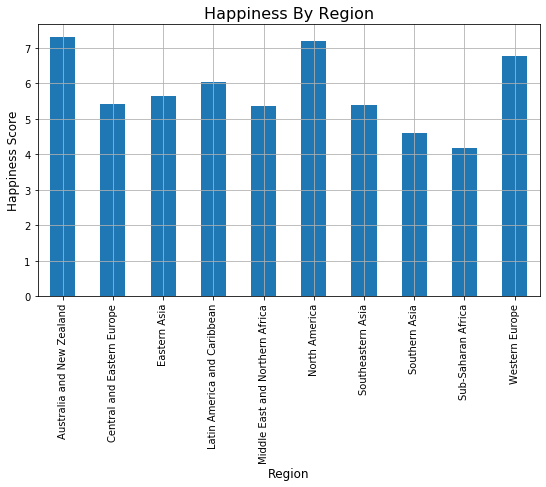

In [9]:
RegionGrouped = DF.groupby('Region')['Happiness Score'].mean()
RegionGrouped.plot.bar()
plt.title("Happiness By Region", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Region",fontsize = 12)
plt.gcf().set_size_inches(9,5)
plt.grid();


In [10]:
subWH = pd.read_csv("submission_world_happiness.csv")


In [11]:
np.unique(DF["Year"])

array([2015, 2016, 2017, 2018, 2019], dtype=int64)

In [12]:
DFcopy[["Country","Region"]]

NameError: name 'DFcopy' is not defined